In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
from pathlib import Path
import json
from courtvision.data import (
    PadelDataset,
    get_keypoints_as_dict,
    CourtVisionDataset,
    dict_to_points,
)
from courtvision.vis import draw_rect, load_image, draw_points, plot_3d_points
from courtvision.geometry import corners_world_3d
import matplotlib.pyplot as plt

In [32]:
CALIBRATION_DATA_PATH = Path(
    "/Users/benjamindecharmoy/projects/courtvision/datasets/calibrations/v1/project-1-at-2023-06-05-11-03-246a0246.json"
)
DATA_ROOT = Path(
    "/Users/benjamindecharmoy/projects/courtvision/courtvision_balldetector/data/labelstudiodata/media"
)

In [33]:
with open(CALIBRATION_DATA_PATH, "r") as fp:
    calibration_keypoints = PadelDataset(samples=json.load(fp))

image = load_image(
    CourtVisionDataset.find_image_path(
        DATA_ROOT, sample=calibration_keypoints.samples[0]
    )
)

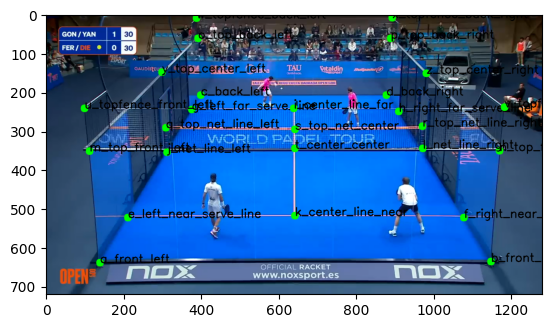

In [34]:
keypoint_dict = get_keypoints_as_dict(
    calibration_keypoints.samples[0].annotations[0].result
)
keypoints, labels = dict_to_points(keypoint_dict)
plt.imshow(draw_points(image.copy(), keypoints, labels=labels))

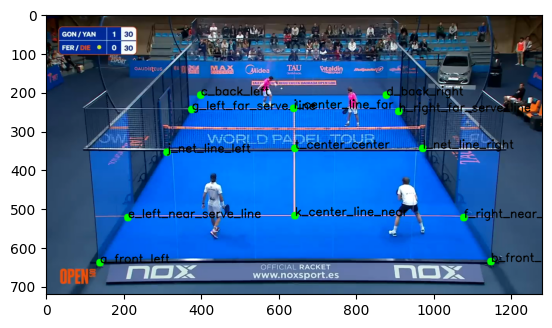

In [37]:
#  Group points into common horizontal planes
floor_plane_dict = dict((k, v) for k, v in keypoint_dict.items() if "top" not in k)
floor_plane_keypoints, floor_plane_labels = dict_to_points(floor_plane_dict)
plt.imshow(draw_points(image.copy(), floor_plane_keypoints, labels=floor_plane_labels))

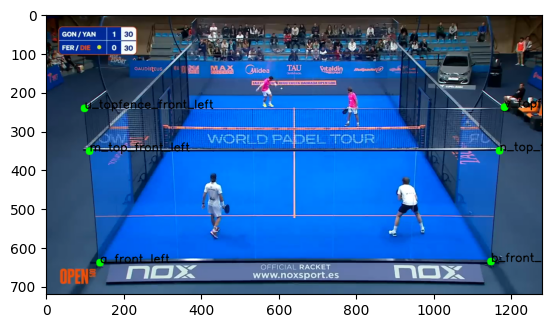

In [38]:
# Group points into common vertical planes (front wall, back wall, left wall, right wall, net)
front_wall_plane_dict = dict((k, v) for k, v in keypoint_dict.items() if "front" in k)
front_wall_plane_keypoints, front_wall_plane_labels = dict_to_points(
    front_wall_plane_dict
)
plt.imshow(
    draw_points(
        image.copy(), front_wall_plane_keypoints, labels=front_wall_plane_labels
    )
)

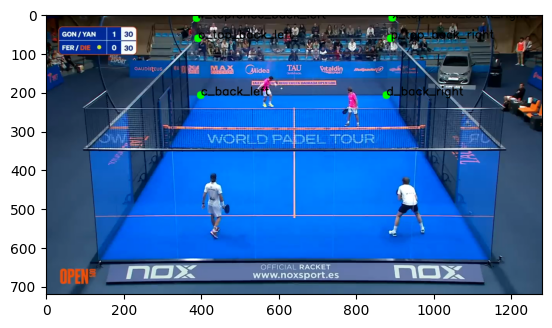

In [39]:
# Group points into common vertical planes (front wall, back wall, left wall, right wall, net)
back_wall_plane_dict = dict((k, v) for k, v in keypoint_dict.items() if "back" in k)
back_wall_plane_keypoints, back_wall_plane_labels = dict_to_points(back_wall_plane_dict)
plt.imshow(
    draw_points(image.copy(), back_wall_plane_keypoints, labels=back_wall_plane_labels)
)

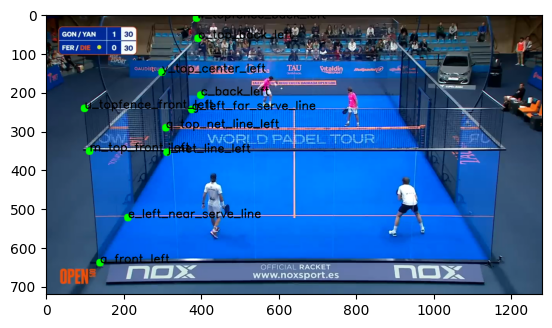

In [40]:
# Group points into common vertical planes (front wall, back wall, left wall, right wall, net)
left_wall_plane_dict = dict((k, v) for k, v in keypoint_dict.items() if "left" in k)
left_wall_plane_keypoints, left_wall_plane_labels = dict_to_points(left_wall_plane_dict)
plt.imshow(
    draw_points(image.copy(), left_wall_plane_keypoints, labels=left_wall_plane_labels)
)

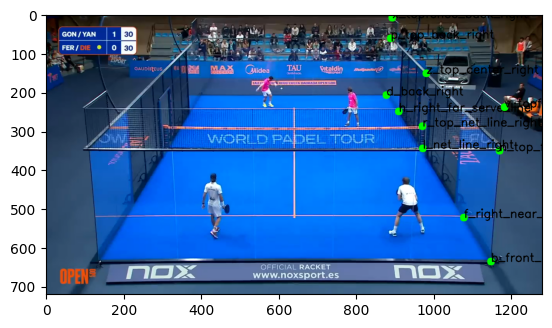

In [41]:
# Group points into common vertical planes (front wall, back wall, left wall, right wall, net)
right_wall_plane_dict = dict((k, v) for k, v in keypoint_dict.items() if "right" in k)
right_wall_plane_keypoints, right_wall_plane_labels = dict_to_points(
    right_wall_plane_dict
)
plt.imshow(
    draw_points(
        image.copy(), right_wall_plane_keypoints, labels=right_wall_plane_labels
    )
)

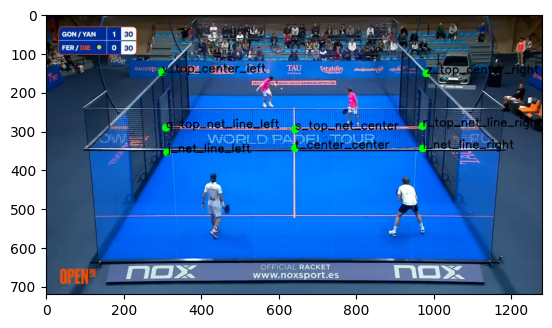

In [43]:
# Group points into common vertical planes (front wall, back wall, left wall, right wall, net)
net_plane_dict = dict(
    (k, v)
    for k, v in keypoint_dict.items()
    if "net" in k or k in ["y_top_center_left", "z_top_center_right", "t_center_center"]
)
net_plane_keypoints, net_plane_labels = dict_to_points(net_plane_dict)
plt.imshow(draw_points(image.copy(), net_plane_keypoints, labels=net_plane_labels))

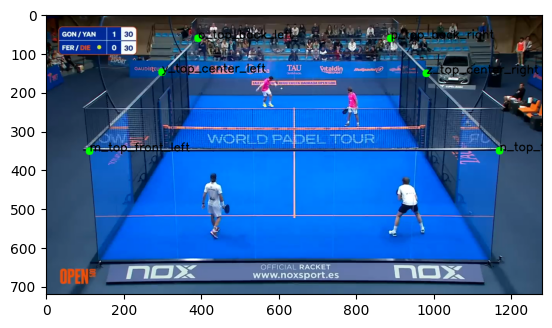

In [46]:
# Group points into common horizontal planes (top and topfence)
top_plane_dict = dict(
    (k, v)
    for k, v in keypoint_dict.items()
    if "top" in k and not "fence" in k and not "net" in k
)
top_plane_keypoints, top_plane_labels = dict_to_points(top_plane_dict)
plt.imshow(draw_points(image.copy(), top_plane_keypoints, labels=top_plane_labels))

(<matplotlib.image.AxesImage at 0x1124887d0>,
 (<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>,
  <Figure size 640x480 with 1 Axes>))

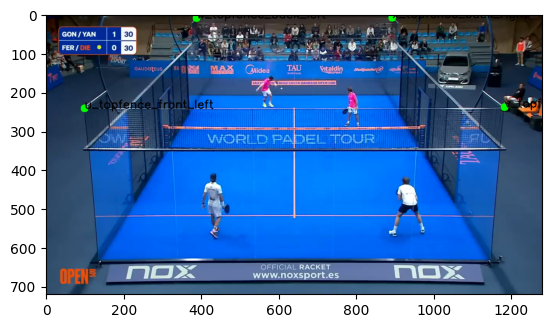

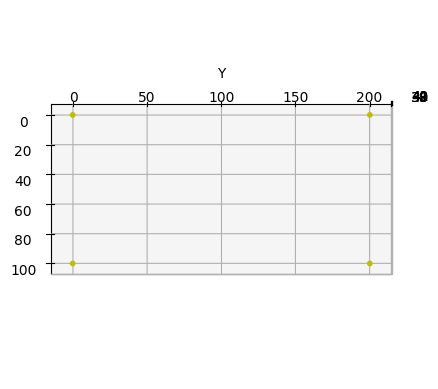

In [70]:
# Group points into common horizontal planes (top and topfence)
topfence_plane_dict = dict((k, v) for k, v in keypoint_dict.items() if "topfence" in k)
top_fence_plane_world_dict = dict(
    (k, v) for k, v in corners_world_3d.items() if "topfence" in k
)

topfence_plane_world_points, topfence_plane_world_labels = dict_to_points(
    top_fence_plane_world_dict
)
topfence_plane_keypoints, topfence_plane_labels = dict_to_points(topfence_plane_dict)

plt.imshow(
    draw_points(image.copy(), topfence_plane_keypoints, labels=topfence_plane_labels)
), plot_3d_points(
    x=topfence_plane_world_points[:, 0],
    y=topfence_plane_world_points[:, 1],
    z=topfence_plane_world_points[:, 2],
)

In [49]:
from courtvision.geometry import corners_world_3d

corners_world_3d

{'a_front_left': (0.0, 0.0, 0.0),
 'b_front_right': (100.0, 0, 0.0),
 'c_back_left': (0.0, 200.0, 0.0),
 'd_back_right': (100.0, 200.0, 0.0),
 'e_left_near_serve_line': (0.0, 20.0, 0.0),
 'f_right_near_serve_line': (100.0, 20.0, 0.0),
 'g_left_far_serve_line': (0.0, 180.0, 0.0),
 'h_right_far_serve_line': (100.0, 180.0, 0.0),
 'i_center_line_far': (50, 180, 0.0),
 'j_net_line_left': (0, 100, 0.0),
 'k_center_line_near': (50, 20, 0.0),
 'l_net_line_right': (100, 100, 0.0),
 'm_top_front_left': (0.0, 0.0, 30.0),
 'n_top_front_right': (100.0, 0, 30.0),
 'o_top_back_left': (0.0, 200.0, 30.0),
 'p_top_back_right': (100.0, 200.0, 30.0),
 'q_top_net_line_left': (0, 100, 7.800000000000001),
 'r_top_net_line_right': (100, 100, 7.800000000000001),
 's_top_net_center': (50.0, 100.0, 7.800000000000001),
 't_center_center': (50.0, 100.0, 0),
 'u_topfence_front_left': (0, 0, 40.0),
 'v_topfence_front_right': (100.0, 0, 40.0),
 'w_topfence_back_left': (0, 200.0, 40.0),
 'x_topfence_back_right': (100.

In [58]:
topfence_plane_world_points

array([[  0.,   0.,  40.],
       [100.,   0.,  40.],
       [  0., 200.,  40.],
       [100., 200.,  40.]], dtype=float32)